In [1]:
!pip install dgl
from os import listdir
import dgl
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

     |████████████████████████████████| 3.0MB 3.5MB/s 


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
epochs = int(input("Enter number of epochs: "))
learning_rate = float(input("Enter learning rate: "))

Enter number of epochs: 260
Enter learning rate: 0.01


In [4]:
filename = "/content/drive/My Drive/bigblue1.nets"

edge_file = "/content/add_edges_2.py"
edge_file_handle = open(edge_file, "w+")

node_count = 0

with open(filename,encoding="utf8") as f:
    netSection = False
    edges = 0
    lineCount = 0
    src=[]
    dest=[]
    for line in f:
        lineCount += 1
        #Newline
        if len(line) < 2:
            continue
            
        # Comments
        if line[0] == '#':
            continue
        #print(line)
        splitLine = line.split()
        #print("Words = ", len(splitLine))
        if(splitLine[0] == 'NetDegree'):
            
            if edges > 0: #Previous NetDegree not complete!
                print("Missed an edge at line: ", lineCount-1)
                
            edges = int(splitLine[2])
            netSection = True
            src=[]
            dest=[]
            #G.add_nodes(num)
            
        elif netSection == True:
          node_name = splitLine[0][1:]
          node_val  = int(node_name)
          if node_count < node_val+1:
              node_count = node_val+1
          
          if(splitLine[1] == 'O'):
              src.append(node_name)
              edges -= 1
          elif(splitLine[1] == 'I'):
              dest.append(node_name)
              edges -= 1
      
        if netSection == True:
            if edges == 0:
                if (len(src)<1):
                    print("No source edge, skipping")
                    continue
                if (len(dest)<1):
                    print("No dest edge, skipping")
                    continue
                    
                netSection = False
                for des_idx in range(len(dest)):
                    cmd = "G.add_edges("+src[0]+","+dest[des_idx]+")"+"\n"
                    edge_file_handle.write(cmd)
                    
        #if lineCount > 100:
        #    break


edge_file_handle.close()


No source edge, skipping
No source edge, skipping
No source edge, skipping
No source edge, skipping
No source edge, skipping
No source edge, skipping
No dest edge, skipping
Missed an edge at line:  90029
No dest edge, skipping
Missed an edge at line:  90050
No dest edge, skipping
Missed an edge at line:  90066
No dest edge, skipping
Missed an edge at line:  90089
No dest edge, skipping
Missed an edge at line:  90111
No source edge, skipping
No source edge, skipping
No source edge, skipping
No source edge, skipping
No source edge, skipping
No source edge, skipping
No source edge, skipping
No source edge, skipping
No source edge, skipping
No source edge, skipping
No dest edge, skipping
Missed an edge at line:  90181
No dest edge, skipping
Missed an edge at line:  90197
No dest edge, skipping
Missed an edge at line:  90214
No dest edge, skipping
Missed an edge at line:  90225
No dest edge, skipping
Missed an edge at line:  90240
No dest edge, skipping
Missed an edge at line:  90251
No des

In [5]:
G = dgl.DGLGraph()
G.add_nodes(node_count)
exec(open(edge_file).read())
print("Nodes = ", G.number_of_nodes())
print("Edges = ", G.number_of_edges())

Nodes =  278164
Edges =  856251


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
embed = nn.Embedding(G.number_of_nodes(),6)

In [0]:
G.ndata['feat'] = embed.weight

In [0]:
from dgl.nn.pytorch import GraphConv

In [0]:
class GCN(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super(GCN,self).__init__()
        self.conv1 = GraphConv(input_size,hidden_size)
        self.conv2 = GraphConv(hidden_size,num_classes)
    
    def forward(self,G,inputs):
        h = self.conv1(G,inputs)
        h = torch.relu(h) 
        h = self.conv2(G,h)
        return h

In [0]:
net = GCN(6,5,20)

In [0]:
inputs = embed.weight
a = np.linspace(0,G.number_of_nodes()-1,20,dtype=int)
labelled_nodes = torch.tensor(a)
labels = torch.tensor([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

# Training Model

In [13]:
import itertools
import time

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=learning_rate)
all_logits = []

start_time = time.time()

for epoch in range(epochs):
    logits = net(G, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labelled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print('Epoch {} | Loss: {}'.format(epoch + 1, loss.item()))

end_time = time.time()
print("Training Time: {}".format(end_time - start_time))

Epoch 1 | Loss: 3.0365405082702637
Epoch 2 | Loss: 3.01357102394104
Epoch 3 | Loss: 2.9913299083709717
Epoch 4 | Loss: 2.969499111175537
Epoch 5 | Loss: 2.9480700492858887
Epoch 6 | Loss: 2.926853895187378
Epoch 7 | Loss: 2.9055843353271484
Epoch 8 | Loss: 2.8841962814331055
Epoch 9 | Loss: 2.8625831604003906
Epoch 10 | Loss: 2.8409628868103027
Epoch 11 | Loss: 2.818999767303467
Epoch 12 | Loss: 2.7964766025543213
Epoch 13 | Loss: 2.773353099822998
Epoch 14 | Loss: 2.7494430541992188
Epoch 15 | Loss: 2.7247862815856934
Epoch 16 | Loss: 2.699439287185669
Epoch 17 | Loss: 2.6734795570373535
Epoch 18 | Loss: 2.6469266414642334
Epoch 19 | Loss: 2.6199629306793213
Epoch 20 | Loss: 2.5925300121307373
Epoch 21 | Loss: 2.5647027492523193
Epoch 22 | Loss: 2.5365686416625977
Epoch 23 | Loss: 2.508150577545166
Epoch 24 | Loss: 2.4797239303588867
Epoch 25 | Loss: 2.451101064682007
Epoch 26 | Loss: 2.4221749305725098
Epoch 27 | Loss: 2.393007278442383
Epoch 28 | Loss: 2.363490581512451
Epoch 29 | L

In [0]:
pos = {}
node_to_cluster_map = np.zeros((G.number_of_nodes(),))
cluster_nodes = {} # Every value in key->value pair includes the cluster centre node as well.
for v in range(G.number_of_nodes()):
  pos[v] = all_logits[99][v].numpy()
  cls = pos[v].argmax()
  node_to_cluster_map[v] = cls
  if cluster_nodes.get(cls) :
    cluster_nodes[cls].append(v)
  else:
    cluster_nodes[cls] = []
    cluster_nodes[cls].append(v)

# Cluster Quality Metric #2 : Number of Nodes per Cluster Distribution

In [0]:
def number_of_nodes_per_cluster():
  number_dict = {} # Dictionary mapping the node label to the number of nodes in a particular cluster
  for key,value in cluster_nodes.items():
    number_dict[key] = len(value)

  number_dict = sorted(number_dict.items()) # Sorting dictionary by keys in increasing order

  for ix in number_dict:
    print("Number of Nodes in Cluster {} = {}\n".format(ix[0],ix[1]))

  return number_dict

In [16]:
number_dict = number_of_nodes_per_cluster()

Number of Nodes in Cluster 0 = 13541

Number of Nodes in Cluster 1 = 14515

Number of Nodes in Cluster 2 = 27538

Number of Nodes in Cluster 3 = 4108

Number of Nodes in Cluster 4 = 4933

Number of Nodes in Cluster 5 = 6708

Number of Nodes in Cluster 6 = 6653

Number of Nodes in Cluster 7 = 2100

Number of Nodes in Cluster 8 = 24845

Number of Nodes in Cluster 9 = 5006

Number of Nodes in Cluster 10 = 7281

Number of Nodes in Cluster 11 = 3852

Number of Nodes in Cluster 12 = 7814

Number of Nodes in Cluster 13 = 28805

Number of Nodes in Cluster 14 = 26234

Number of Nodes in Cluster 15 = 219

Number of Nodes in Cluster 16 = 24446

Number of Nodes in Cluster 17 = 43844

Number of Nodes in Cluster 18 = 17572

Number of Nodes in Cluster 19 = 8150



# HashMap (Dictionary) for easy visualization of networkx graph
- Dictionary to map node numbers in a particular cluster to a standard count procedure of 0 to (n-1) 
- n = number of nodes in a particular cluster
- Cluster label is taken as input from user

In [0]:
num = int(input("Enter cluster number: "))

Enter cluster number: 10


In [0]:
standard_nodes_dict = {}

count = 0

for node in cluster_nodes[num]:
  standard_nodes_dict[node] = count
  count += 1

In [0]:
print(standard_nodes_dict.items())

dict_items([(44, 0), (45, 1), (48, 2), (49, 3), (88, 4), (89, 5), (90, 6), (137, 7), (140, 8), (192, 9), (193, 10), (194, 11), (200, 12), (201, 13), (202, 14), (232, 15), (233, 16), (234, 17), (256, 18), (257, 19), (258, 20), (263, 21), (280, 22), (281, 23), (282, 24), (284, 25), (285, 26), (286, 27), (296, 28), (297, 29), (298, 30), (303, 31), (345, 32), (346, 33), (347, 34), (357, 35), (358, 36), (359, 37), (387, 38), (388, 39), (389, 40), (396, 41), (397, 42), (398, 43), (443, 44), (459, 45), (462, 46), (503, 47), (504, 48), (505, 49), (539, 50), (540, 51), (541, 52), (557, 53), (558, 54), (559, 55), (563, 56), (564, 57), (565, 58), (623, 59), (629, 60), (638, 61), (682, 62), (683, 63), (704, 64), (713, 65), (725, 66), (739, 67), (802, 68), (805, 69), (806, 70), (849, 71), (931, 72), (933, 73), (1060, 74), (1061, 75), (1068, 76), (1069, 77), (1113, 78), (1132, 79), (1135, 80), (1152, 81), (1156, 82), (1236, 83), (1242, 84), (1295, 85), (1296, 86), (1301, 87), (1302, 88), (1321, 89),

# Clustering Visualisation: Cluster Quality Metric # 3
- Visualisation for any generic cluster label taken as input from user

In [0]:
# dict_keys = list(standard_nodes_dict.keys())

# input_edges = G.in_edges(dict_keys, form='uv')

# ax = input_edges[0].numpy()

# ax = [i for i in ax if i in standard_nodes_dict.keys()]

# print(ax)

In [0]:
src = []
dst = []

In [0]:
def build_graph():

  dict_keys = list(standard_nodes_dict.keys())

  input_edges = G.in_edges(dict_keys, form='uv')

  src = input_edges[0].numpy()
  dst = input_edges[1].numpy()

  m = src.shape[0]
  src1 = []
  dst1 = []

  for ix in range(m):
    if src[ix] not in standard_nodes_dict.keys():
      continue
    else:
      src1.append(src[ix])
      dst1.append(dst[ix])

  src1 = np.array(src1)
  dst1 = np.array(dst1)

  j = 0
  for num in src1:
    num = standard_nodes_dict.get(num)
    src1[j] = num
    j += 1

  i = 0
  for num1 in dst1:
      num1 = standard_nodes_dict[num1]
      dst1[i] = num1
      i += 1

  u = np.concatenate([src1,dst1])
  v = np.concatenate([dst1,src1])

  return dgl.DGLGraph((u,v))

In [0]:
G1 = build_graph()

In [0]:
print("Nodes = {}".format(G1.number_of_nodes()))
print("Edges = {}".format(G1.number_of_edges()))

Nodes = 14718
Edges = 14738


In [0]:
nx_G1 = G1.to_networkx().to_undirected()

In [0]:
# nx.write_edgelist(nx_G1,"/content/cluster14.csv")

In [0]:
# pos1 = nx.kamada_kawai_layout(nx_G1) # Session crashes on running this cell

In [0]:
# plt.style.use("seaborn")

In [0]:
# nx.draw(nx_G1,pos1,with_labels=True,node_color=[[0.7,0.7,0.7]])
# plt.show()

TESTING

In [0]:
test_dict = {
    "(1,2)" : 4,
    "(3,4)" : 2,
    "(5,6)" : 7
}

keys = test_dict.keys()
values = test_dict.values()

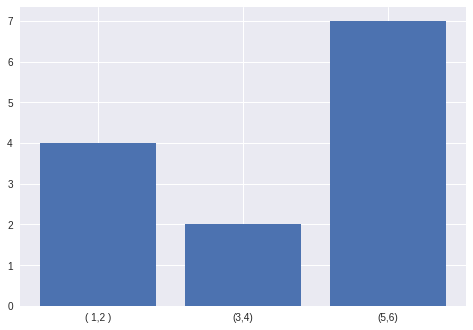

In [61]:
plt.bar(keys,values)
plt.show()

# Cluster Quality Metric # 1: Total number of edges between nodes which belong to different clusters and intercluster score
- Intercluster Score = No. of edges between 2 clusters / Sum of the number of nodes in the two clusters

In [0]:
def find_cluster(node):
  return node_to_cluster_map[node]

In [71]:
edges_dict = {}

start = time.time()

for node in range(G.number_of_nodes()):
  #print("Node {}".format(node))
  # node is the source node for all out edges

  out_edges = G.out_edges(node,form='uv')

  src = out_edges[0]
  if(len(src) < 1):
    continue
    
  if src[-1] != node:
    print("Source node is different from node")
  dst = out_edges[1]

  src_cluster = find_cluster(node)

  for ix in range(src.shape[0]):
    #node_n = src[ix]
    node_n = node
    node_m = dst[ix]

    #cluster_n = find_cluster(node_n)
    cluster_n = src_cluster
    cluster_m = find_cluster(node_m)

    if cluster_n != cluster_m:
      from_cluster = cluster_n
      to_cluster = cluster_m
      if from_cluster > to_cluster:
        from_cluster = cluster_m
        to_cluster = cluster_n

      if (from_cluster,to_cluster) not in edges_dict.keys():
        edges_dict[(from_cluster,to_cluster)] = 1
      else:
        edges_dict[(from_cluster,to_cluster)] += 1


for key,value in edges_dict.items():
  num = value
  nodes_1 = number_dict[int(key[0])][1]
  nodes_2 = number_dict[int(key[1])][1]
  num2 = value/int((nodes_1 + nodes_2))
  num2 = round(num2,4)

  edges_dict[key] = (num,num2)


end = time.time()
print("\nTime taken: {}".format(end - start))


Time taken: 40.12416124343872


In [72]:
count = 0
for key,value in edges_dict.items():
  count += 1
print("Entries in edges_dict = {}".format(count))

Entries in edges_dict = 190


In [73]:
for key, value in (edges_dict.items()):
  print(key,value)

(0.0, 1.0) (4186, 0.1492)
(0.0, 10.0) (1806, 0.0867)
(2.0, 13.0) (21059, 0.3738)
(2.0, 16.0) (14876, 0.2862)
(2.0, 14.0) (16757, 0.3116)
(0.0, 5.0) (2095, 0.1035)
(0.0, 4.0) (1395, 0.0755)
(0.0, 14.0) (7912, 0.1989)
(8.0, 14.0) (15257, 0.2987)
(0.0, 8.0) (5802, 0.1511)
(6.0, 8.0) (3783, 0.1201)
(8.0, 13.0) (16951, 0.316)
(1.0, 14.0) (8843, 0.217)
(14.0, 19.0) (5014, 0.1458)
(0.0, 2.0) (5817, 0.1416)
(8.0, 17.0) (28352, 0.4128)
(2.0, 17.0) (33506, 0.4694)
(0.0, 13.0) (6258, 0.1478)
(12.0, 17.0) (4858, 0.094)
(13.0, 18.0) (11179, 0.241)
(17.0, 18.0) (18556, 0.3021)
(1.0, 5.0) (2050, 0.0966)
(0.0, 19.0) (2287, 0.1054)
(16.0, 17.0) (23040, 0.3374)
(16.0, 18.0) (9003, 0.2143)
(13.0, 19.0) (4075, 0.1103)
(3.0, 14.0) (2216, 0.073)
(2.0, 18.0) (10421, 0.231)
(1.0, 16.0) (7238, 0.1858)
(13.0, 14.0) (16435, 0.2986)
(13.0, 17.0) (32000, 0.4405)
(2.0, 9.0) (2270, 0.0698)
(4.0, 8.0) (2107, 0.0708)
(0.0, 17.0) (8533, 0.1487)
(11.0, 19.0) (617, 0.0514)
(0.0, 12.0) (2272, 0.1064)
(13.0, 16.0) (15467, 

In [0]:
edges_list = sorted(edges_dict.items(),reverse=True,key = lambda x: x[1])

In [76]:
edges_list[:10]

[((2.0, 17.0), (33506, 0.4694)),
 ((13.0, 17.0), (32000, 0.4405)),
 ((8.0, 17.0), (28352, 0.4128)),
 ((14.0, 17.0), (26720, 0.3813)),
 ((16.0, 17.0), (23040, 0.3374)),
 ((2.0, 13.0), (21059, 0.3738)),
 ((17.0, 18.0), (18556, 0.3021)),
 ((2.0, 8.0), (18077, 0.3451)),
 ((8.0, 13.0), (16951, 0.316)),
 ((2.0, 14.0), (16757, 0.3116))]

In [0]:
keys_list = []
values_list = []

count = 0
for val in edges_list:
  count += 1
  keys_list.append(str(val[0]))
  values_list.append(val[1][0])
  if(count == 10):
    break

In [80]:
print(keys_list)

['(2.0, 17.0)', '(13.0, 17.0)', '(8.0, 17.0)', '(14.0, 17.0)', '(16.0, 17.0)', '(2.0, 13.0)', '(17.0, 18.0)', '(2.0, 8.0)', '(8.0, 13.0)', '(2.0, 14.0)']


In [81]:
values_list

[33506, 32000, 28352, 26720, 23040, 21059, 18556, 18077, 16951, 16757]

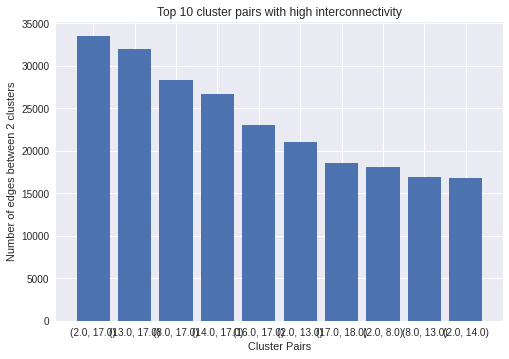

In [82]:
plt.style.use("seaborn")
plt.bar(keys_list,values_list)
plt.ylabel("Number of edges between 2 clusters")
plt.xlabel("Cluster Pairs")
plt.title("Top 10 cluster pairs with high interconnectivity")
plt.show()